In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
csv_file_path = os.path.join(current_folder, "Data", "10-03-21-binance-btc-1hr.csv")

# creating a pandas dataframe from CSV
df = pd.read_csv(csv_file_path)

# dataframe is sorted from newst to oldest, reverse order:
df = df[::-1]

end_point = date(2021, 3, 9)
start_point = end_point - timedelta(90)

# converting date column to datetime objects
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtering the dates
filter_dates = df['date'] >= pd.to_datetime(start_point)
timeperiod_df = df[filter_dates]
filter_dates = timeperiod_df['date'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

# Dropping columns
timeperiod_df = timeperiod_df.drop(columns=['unix', 'date', 'symbol', 'Volume USDT', 'tradecount'])



In [2]:
# setting training and validation splits
# total number = 22178, so 1178 train, 500 val, 500 test
training_samples = 1178
validation_samples = 500

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 3, training_samples, validation_samples, lookback, step, delay, batch_size)

shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1178th, validation: 1678th, test: 2154th
Input shape: (128, 120, 5)
Target shape: (128, 1)


In [3]:
len(timeperiod_df)

2154

I am not sure why there are 6 less samples than expected (90x24=2160). I will have to look into this... maybe another reason why setting up a price history scraper is preferable.

Also the last set of experiments are all void, I accidentally left `num_training = 12000` and `num_validation = 7000` hard coded in the normalise data function... which means data was normalised over the entire dataset, rather than just over the training data...

I think a thorough comb through of the code is in order at some point...

In [4]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(32, activation='relu'))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
9/9 [==============================] - 7s 355ms/step - loss: 0.5792 - val_loss: 3.0491
Epoch 2/20
9/9 [==============================] - 2s 275ms/step - loss: 0.1564 - val_loss: 1.4730
Epoch 3/20
9/9 [==============================] - 2s 279ms/step - loss: 0.1100 - val_loss: 1.5172
Epoch 4/20
9/9 [==============================] - 3s 287ms/step - loss: 0.0808 - val_loss: 1.4931
Epoch 5/20
9/9 [==============================] - 2s 282ms/step - loss: 0.0761 - val_loss: 1.5636
Epoch 6/20
9/9 [==============================] - 2s 275ms/step - loss: 0.0731 - val_loss: 1.6199
Epoch 7/20
9/9 [==============================] - 3s 320ms/step - loss: 0.0701 - val_loss: 1.7013
Epoch 8/20
9/9 [==============================] - 2s 280ms/step - loss: 0.1042 - val_loss: 1.6798
Epoch 9/20
9/9 [==============================] - 3s 336ms/step - loss: 0.0758 - val_loss: 1.6892
Epoch 10/20
9/9 [==============================] - 3s 280ms/step - loss: 0.0727 - val_loss: 1.7020
Epoch 11/20
9/9 [==

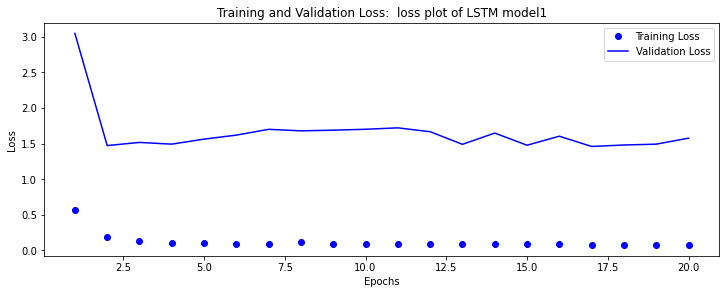

In [5]:
plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

In [6]:
RNN_model1 = models.Sequential()
RNN_model1.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model1.add(layers.SimpleRNN(32, activation='relu'))


RNN_model1.add(layers.Dense(1))

RNN_model1.compile(optimizer=RMSprop(), loss='mse')
RNN_model1_history = RNN_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
9/9 [==============================] - 3s 195ms/step - loss: 1.2456 - val_loss: 3.8182
Epoch 2/20
9/9 [==============================] - 1s 165ms/step - loss: 0.2689 - val_loss: 2.7428
Epoch 3/20
9/9 [==============================] - 1s 167ms/step - loss: 0.1568 - val_loss: 2.4579
Epoch 4/20
9/9 [==============================] - 1s 165ms/step - loss: 0.1253 - val_loss: 2.3043
Epoch 5/20
9/9 [==============================] - 1s 159ms/step - loss: 0.1065 - val_loss: 2.1647
Epoch 6/20
9/9 [==============================] - 1s 166ms/step - loss: 0.0935 - val_loss: 1.9890
Epoch 7/20
9/9 [==============================] - 2s 170ms/step - loss: 0.0828 - val_loss: 1.8679
Epoch 8/20
9/9 [==============================] - 1s 165ms/step - loss: 0.0762 - val_loss: 1.7652
Epoch 9/20
9/9 [==============================] - 1s 151ms/step - loss: 0.0719 - val_loss: 1.6762
Epoch 10/20
9/9 [==============================] - 1s 161ms/step - loss: 0.0679 - val_loss: 1.6445
Epoch 11/20
9/9 [==

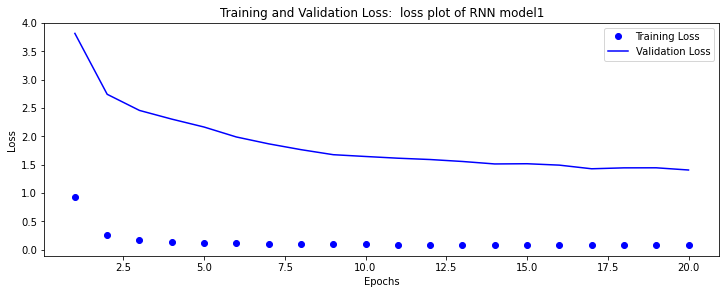

In [7]:
plot_simple_loss(RNN_model1_history, "loss plot of RNN model1")

In [8]:
LSTM_model2 = models.Sequential()
LSTM_model2.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model2.add(layers.LSTM(16, activation='relu'))


LSTM_model2.add(layers.Dense(1))

LSTM_model2.compile(optimizer=RMSprop(), loss='mse')
LSTM_model2_history = LSTM_model2.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 7s 315ms/step - loss: 0.8646 - val_loss: 3.6363
Epoch 2/40
9/9 [==============================] - 2s 255ms/step - loss: 0.4576 - val_loss: 2.2426
Epoch 3/40
9/9 [==============================] - 2s 248ms/step - loss: 0.2374 - val_loss: 2.0649
Epoch 4/40
9/9 [==============================] - 2s 253ms/step - loss: 0.1242 - val_loss: 2.0171
Epoch 5/40
9/9 [==============================] - 2s 252ms/step - loss: 0.0837 - val_loss: 1.9767
Epoch 6/40
9/9 [==============================] - 2s 257ms/step - loss: 0.0777 - val_loss: 1.9330
Epoch 7/40
9/9 [==============================] - 2s 263ms/step - loss: 0.0750 - val_loss: 1.8883
Epoch 8/40
9/9 [==============================] - 2s 270ms/step - loss: 0.0728 - val_loss: 1.8452
Epoch 9/40
9/9 [==============================] - 2s 254ms/step - loss: 0.0707 - val_loss: 1.8009
Epoch 10/40
9/9 [==============================] - 2s 262ms/step - loss: 0.0696 - val_loss: 1.7647
Epoch 11/40
9/9 [==

In [9]:
RNN_model2 = models.Sequential()
RNN_model2.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model2.add(layers.SimpleRNN(16, activation='relu'))


RNN_model2.add(layers.Dense(1))

RNN_model2.compile(optimizer=RMSprop(), loss='mse')
RNN_model2_history = RNN_model2.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 4s 207ms/step - loss: 0.5171 - val_loss: 2.2187
Epoch 2/40
9/9 [==============================] - 2s 168ms/step - loss: 0.2098 - val_loss: 1.9313
Epoch 3/40
9/9 [==============================] - 2s 177ms/step - loss: 0.1528 - val_loss: 1.7823
Epoch 4/40
9/9 [==============================] - 2s 184ms/step - loss: 0.1291 - val_loss: 1.6872
Epoch 5/40
9/9 [==============================] - 1s 152ms/step - loss: 0.1135 - val_loss: 1.6257
Epoch 6/40
9/9 [==============================] - 2s 174ms/step - loss: 0.1021 - val_loss: 1.6032
Epoch 7/40
9/9 [==============================] - 2s 178ms/step - loss: 0.0950 - val_loss: 1.5798
Epoch 8/40
9/9 [==============================] - 1s 161ms/step - loss: 0.0883 - val_loss: 1.5474
Epoch 9/40
9/9 [==============================] - 2s 177ms/step - loss: 0.0814 - val_loss: 1.5357
Epoch 10/40
9/9 [==============================] - 2s 173ms/step - loss: 0.0786 - val_loss: 1.5063
Epoch 11/40
9/9 [==

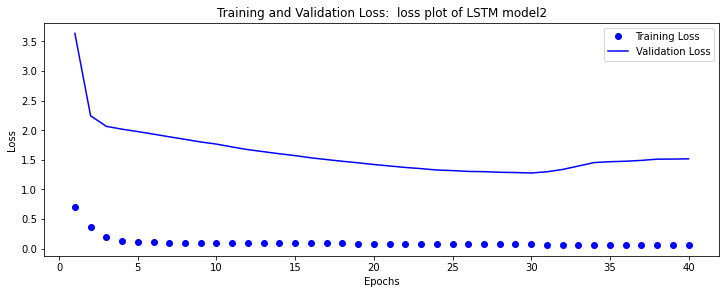

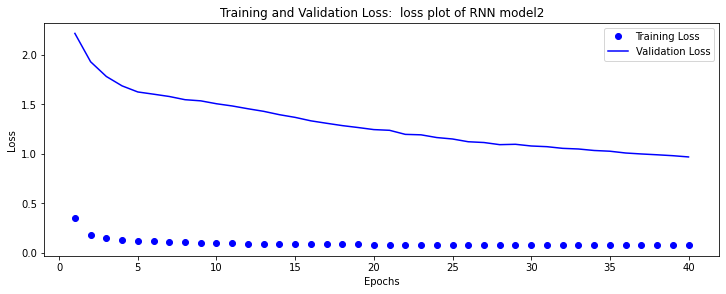

In [10]:
plot_simple_loss(LSTM_model2_history, "loss plot of LSTM model2")
plot_simple_loss(RNN_model2_history, "loss plot of RNN model2")

In [11]:
LSTM_model3 = models.Sequential()
LSTM_model3.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model3.add(layers.LSTM(32, activation='relu'))


LSTM_model3.add(layers.Dense(1))

LSTM_model3.compile(optimizer=RMSprop(), loss='mse')
LSTM_model3_history = LSTM_model3.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 8s 364ms/step - loss: 0.5708 - val_loss: 1.3176
Epoch 2/40
9/9 [==============================] - 3s 288ms/step - loss: 0.1839 - val_loss: 1.4303
Epoch 3/40
9/9 [==============================] - 2s 268ms/step - loss: 0.0905 - val_loss: 1.0967
Epoch 4/40
9/9 [==============================] - 2s 274ms/step - loss: 0.1086 - val_loss: 0.9206
Epoch 5/40
9/9 [==============================] - 3s 285ms/step - loss: 0.0992 - val_loss: 1.0409
Epoch 6/40
9/9 [==============================] - 3s 303ms/step - loss: 0.0681 - val_loss: 1.1622
Epoch 7/40
9/9 [==============================] - 3s 293ms/step - loss: 0.0669 - val_loss: 1.2581
Epoch 8/40
9/9 [==============================] - 2s 283ms/step - loss: 0.0659 - val_loss: 1.3187
Epoch 9/40
9/9 [==============================] - 3s 284ms/step - loss: 0.0640 - val_loss: 1.3648
Epoch 10/40
9/9 [==============================] - 3s 292ms/step - loss: 0.0771 - val_loss: 1.3645
Epoch 11/40
9/9 [==

In [12]:
RNN_model3 = models.Sequential()
RNN_model3.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model3.add(layers.SimpleRNN(32, activation='relu'))


RNN_model3.add(layers.Dense(1))

RNN_model3.compile(optimizer=RMSprop(), loss='mse')
RNN_model3_history = RNN_model3.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 4s 190ms/step - loss: 0.4913 - val_loss: 2.6735
Epoch 2/40
9/9 [==============================] - 1s 165ms/step - loss: 0.1913 - val_loss: 2.2382
Epoch 3/40
9/9 [==============================] - 1s 167ms/step - loss: 0.1180 - val_loss: 2.0312
Epoch 4/40
9/9 [==============================] - 1s 166ms/step - loss: 0.0980 - val_loss: 1.8643
Epoch 5/40
9/9 [==============================] - 1s 169ms/step - loss: 0.0882 - val_loss: 1.7258
Epoch 6/40
9/9 [==============================] - 1s 147ms/step - loss: 0.0792 - val_loss: 1.6829
Epoch 7/40
9/9 [==============================] - 1s 167ms/step - loss: 0.0759 - val_loss: 1.6183
Epoch 8/40
9/9 [==============================] - 1s 164ms/step - loss: 0.0718 - val_loss: 1.5448
Epoch 9/40
9/9 [==============================] - 1s 158ms/step - loss: 0.0698 - val_loss: 1.5493
Epoch 10/40
9/9 [==============================] - 1s 164ms/step - loss: 0.0674 - val_loss: 1.4795
Epoch 11/40
9/9 [==

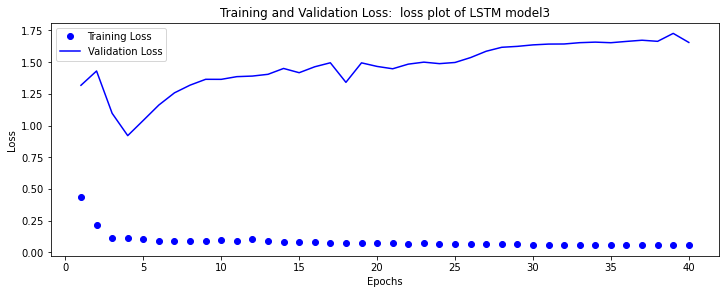

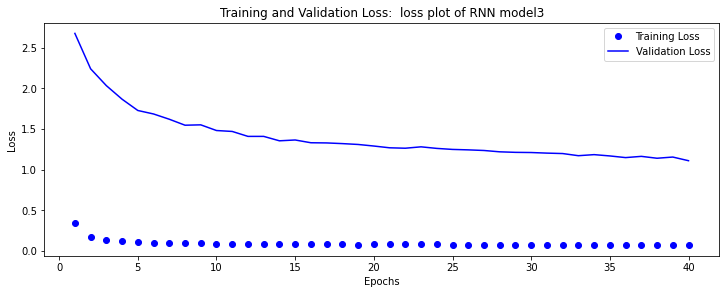

In [13]:
plot_simple_loss(LSTM_model3_history, "loss plot of LSTM model3")
plot_simple_loss(RNN_model3_history, "loss plot of RNN model3")

In [14]:
LSTM_model4 = models.Sequential()
LSTM_model4.add(layers.LSTM(16, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model4.add(layers.LSTM(16, activation='relu'))


LSTM_model4.add(layers.Dense(1))

LSTM_model4.compile(optimizer=RMSprop(), loss='mse')
LSTM_model4_history = LSTM_model4.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 7s 383ms/step - loss: 0.7105 - val_loss: 2.1900
Epoch 2/40
9/9 [==============================] - 2s 243ms/step - loss: 0.5201 - val_loss: 1.1110
Epoch 3/40
9/9 [==============================] - 2s 244ms/step - loss: 0.4411 - val_loss: 1.0996
Epoch 4/40
9/9 [==============================] - 2s 245ms/step - loss: 0.3721 - val_loss: 1.0972
Epoch 5/40
9/9 [==============================] - 2s 242ms/step - loss: 0.2844 - val_loss: 1.1460
Epoch 6/40
9/9 [==============================] - 2s 242ms/step - loss: 2290085964.8198 - val_loss: 1.0327
Epoch 7/40
9/9 [==============================] - 2s 226ms/step - loss: 0.1489 - val_loss: 0.9849
Epoch 8/40
9/9 [==============================] - 2s 231ms/step - loss: 0.1480 - val_loss: 0.9455
Epoch 9/40
9/9 [==============================] - 2s 238ms/step - loss: 0.1473 - val_loss: 0.9158
Epoch 10/40
9/9 [==============================] - 2s 238ms/step - loss: 0.1467 - val_loss: 0.8948
Epoch 11/4

In [16]:
RNN_model4 = models.Sequential()
RNN_model4.add(layers.SimpleRNN(16, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model4.add(layers.SimpleRNN(16, activation='relu'))


RNN_model4.add(layers.Dense(1))

RNN_model4.compile(optimizer=RMSprop(), loss='mse')
RNN_model4_history = RNN_model4.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 4s 198ms/step - loss: 1.8806 - val_loss: 1.6917
Epoch 2/40
9/9 [==============================] - 2s 189ms/step - loss: 1.0875 - val_loss: 1.4733
Epoch 3/40
9/9 [==============================] - 2s 185ms/step - loss: 0.6915 - val_loss: 1.3401
Epoch 4/40
9/9 [==============================] - 2s 188ms/step - loss: 0.4538 - val_loss: 1.2364
Epoch 5/40
9/9 [==============================] - 2s 169ms/step - loss: 0.3078 - val_loss: 1.0971
Epoch 6/40
9/9 [==============================] - 2s 191ms/step - loss: 0.2162 - val_loss: 1.0044
Epoch 7/40
9/9 [==============================] - 2s 175ms/step - loss: 0.1682 - val_loss: 0.9221
Epoch 8/40
9/9 [==============================] - 2s 190ms/step - loss: 0.1453 - val_loss: 0.8509
Epoch 9/40
9/9 [==============================] - 2s 178ms/step - loss: 0.1325 - val_loss: 0.8123
Epoch 10/40
9/9 [==============================] - 2s 174ms/step - loss: 0.1219 - val_loss: 0.7766
Epoch 11/40
9/9 [==

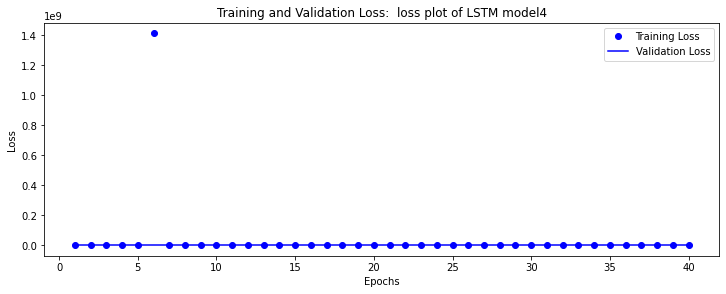

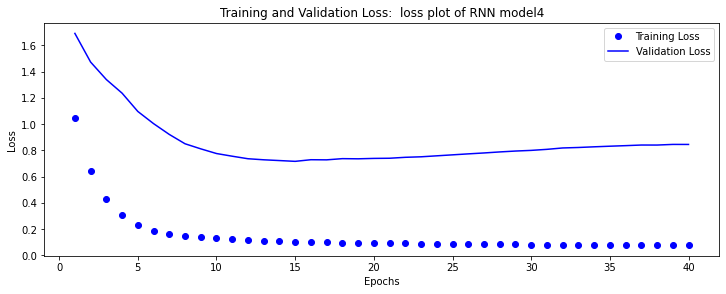

In [17]:
plot_simple_loss(LSTM_model4_history, "loss plot of LSTM model4")
plot_simple_loss(RNN_model4_history, "loss plot of RNN model4")

In [18]:
LSTM_model5 = models.Sequential()
LSTM_model5.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model5.add(layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


LSTM_model5.add(layers.Dense(1))

LSTM_model5.compile(optimizer=RMSprop(), loss='mse')
LSTM_model5_history = LSTM_model5.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 12s 419ms/step - loss: 0.5712 - val_loss: 2.0298
Epoch 2/40
9/9 [==============================] - 3s 361ms/step - loss: 0.2140 - val_loss: 1.4642
Epoch 3/40
9/9 [==============================] - 3s 349ms/step - loss: 0.1085 - val_loss: 1.5306
Epoch 4/40
9/9 [==============================] - 3s 356ms/step - loss: 0.0857 - val_loss: 1.5245
Epoch 5/40
9/9 [==============================] - 3s 359ms/step - loss: 0.0839 - val_loss: 1.5778
Epoch 6/40
9/9 [==============================] - 3s 365ms/step - loss: 0.0834 - val_loss: 1.5417
Epoch 7/40
9/9 [==============================] - 3s 348ms/step - loss: 0.0803 - val_loss: 1.5211
Epoch 8/40
9/9 [==============================] - 3s 360ms/step - loss: 0.0877 - val_loss: 1.5037
Epoch 9/40
9/9 [==============================] - 3s 361ms/step - loss: 0.0760 - val_loss: 1.5351
Epoch 10/40
9/9 [==============================] - 3s 371ms/step - loss: 0.0734 - val_loss: 1.5420
Epoch 11/40
9/9 [=

In [19]:
RNN_model5 = models.Sequential()
RNN_model5.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model5.add(layers.SimpleRNN(16, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


RNN_model5.add(layers.Dense(1))

RNN_model5.compile(optimizer=RMSprop(), loss='mse')
RNN_model5_history = RNN_model5.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 4s 204ms/step - loss: 1.0971 - val_loss: 2.8189
Epoch 2/40
9/9 [==============================] - 2s 182ms/step - loss: 0.6458 - val_loss: 2.1329
Epoch 3/40
9/9 [==============================] - 2s 177ms/step - loss: 0.4920 - val_loss: 1.9635
Epoch 4/40
9/9 [==============================] - 2s 184ms/step - loss: 0.3788 - val_loss: 1.8151
Epoch 5/40
9/9 [==============================] - 2s 191ms/step - loss: 0.4077 - val_loss: 1.8281
Epoch 6/40
9/9 [==============================] - 2s 189ms/step - loss: 0.3355 - val_loss: 1.7366
Epoch 7/40
9/9 [==============================] - 1s 166ms/step - loss: 0.3312 - val_loss: 1.6327
Epoch 8/40
9/9 [==============================] - 2s 174ms/step - loss: 0.2928 - val_loss: 1.7649
Epoch 9/40
9/9 [==============================] - 2s 192ms/step - loss: 0.2649 - val_loss: 1.7516
Epoch 10/40
9/9 [==============================] - 2s 187ms/step - loss: 0.2576 - val_loss: 1.7074
Epoch 11/40
9/9 [==

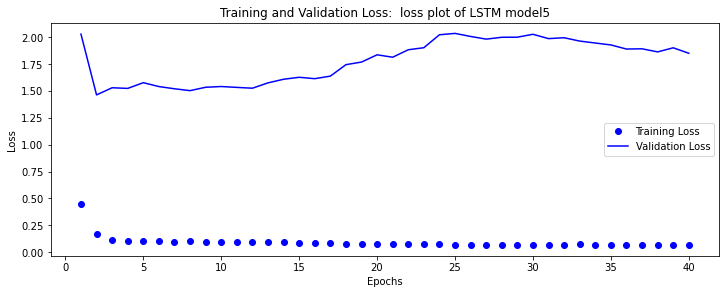

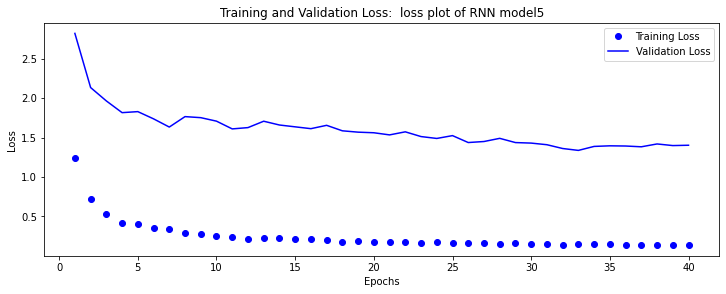

In [20]:
plot_simple_loss(LSTM_model5_history, "loss plot of LSTM model5")
plot_simple_loss(RNN_model5_history, "loss plot of RNN model5")

In [21]:
LSTM_model6 = models.Sequential()
LSTM_model6.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model6.add(layers.LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
LSTM_model6.add(layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


LSTM_model6.add(layers.Dense(1))

LSTM_model6.compile(optimizer=RMSprop(), loss='mse')
LSTM_model6_history = LSTM_model6.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 12s 625ms/step - loss: 0.7750 - val_loss: 3.7969
Epoch 2/40
9/9 [==============================] - 5s 486ms/step - loss: 0.4191 - val_loss: 2.5819
Epoch 3/40
9/9 [==============================] - 4s 418ms/step - loss: 0.4271 - val_loss: 1.7438
Epoch 4/40
9/9 [==============================] - 4s 439ms/step - loss: 0.2346 - val_loss: 1.8391
Epoch 5/40
9/9 [==============================] - 4s 414ms/step - loss: 0.2187 - val_loss: 1.9167
Epoch 6/40
9/9 [==============================] - 4s 429ms/step - loss: 0.1942 - val_loss: 1.9853
Epoch 7/40
9/9 [==============================] - 4s 411ms/step - loss: 0.1766 - val_loss: 2.0512
Epoch 8/40
9/9 [==============================] - 5s 480ms/step - loss: 0.1481 - val_loss: 2.1869
Epoch 9/40
9/9 [==============================] - 4s 442ms/step - loss: 0.1253 - val_loss: 2.2339
Epoch 10/40
9/9 [==============================] - 4s 450ms/step - loss: 0.1108 - val_loss: 2.3091
Epoch 11/40
9/9 [=

In [22]:
RNN_model6 = models.Sequential()
RNN_model6.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model6.add(layers.SimpleRNN(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
RNN_model6.add(layers.SimpleRNN(16, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


RNN_model6.add(layers.Dense(1))

RNN_model6.compile(optimizer=RMSprop(), loss='mse')
RNN_model6_history = RNN_model6.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 5s 252ms/step - loss: 3.7589 - val_loss: 5.4439
Epoch 2/40
9/9 [==============================] - 2s 225ms/step - loss: 1.1026 - val_loss: 2.9800
Epoch 3/40
9/9 [==============================] - 2s 223ms/step - loss: 0.7745 - val_loss: 2.1616
Epoch 4/40
9/9 [==============================] - 2s 228ms/step - loss: 0.5965 - val_loss: 1.8666
Epoch 5/40
9/9 [==============================] - 2s 219ms/step - loss: 0.5653 - val_loss: 1.8294
Epoch 6/40
9/9 [==============================] - 2s 214ms/step - loss: 0.5110 - val_loss: 1.9631
Epoch 7/40
9/9 [==============================] - 2s 217ms/step - loss: 0.4441 - val_loss: 1.8613
Epoch 8/40
9/9 [==============================] - 2s 218ms/step - loss: 0.3911 - val_loss: 1.9380
Epoch 9/40
9/9 [==============================] - 2s 225ms/step - loss: 0.3659 - val_loss: 1.8747
Epoch 10/40
9/9 [==============================] - 2s 199ms/step - loss: 0.3260 - val_loss: 1.8741
Epoch 11/40
9/9 [==

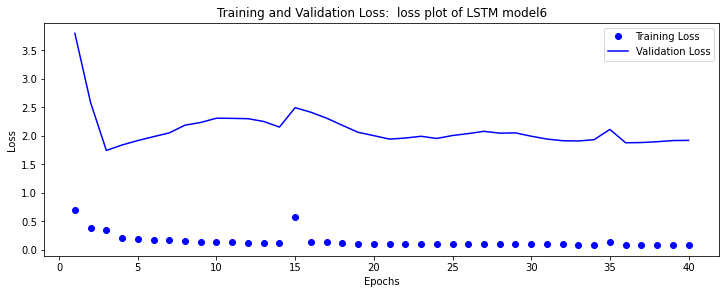

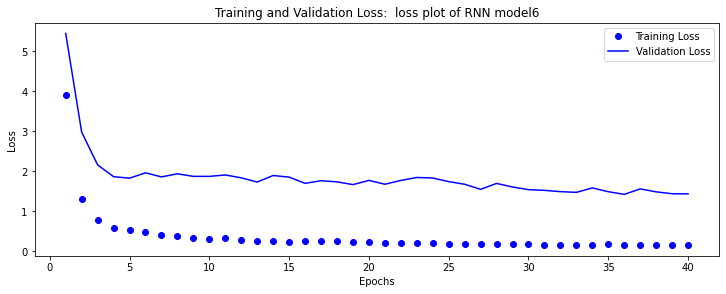

In [23]:
plot_simple_loss(LSTM_model6_history, "loss plot of LSTM model6")
plot_simple_loss(RNN_model6_history, "loss plot of RNN model6")

In [24]:
LSTM_model7 = models.Sequential()
LSTM_model7.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model7.add(layers.LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
LSTM_model7.add(layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


LSTM_model7.add(layers.Dense(1))

LSTM_model7.compile(optimizer=RMSprop(), loss='mse')
LSTM_model7_history = LSTM_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 12s 508ms/step - loss: 1.1290 - val_loss: 3.3462
Epoch 2/40
9/9 [==============================] - 4s 405ms/step - loss: 0.7713 - val_loss: 2.8447
Epoch 3/40
9/9 [==============================] - 3s 384ms/step - loss: 0.6947 - val_loss: 2.7815
Epoch 4/40
9/9 [==============================] - 3s 394ms/step - loss: 0.6715 - val_loss: 2.7081
Epoch 5/40
9/9 [==============================] - 4s 466ms/step - loss: 0.6437 - val_loss: 2.6134
Epoch 6/40
9/9 [==============================] - 4s 493ms/step - loss: 0.6029 - val_loss: 2.4855
Epoch 7/40
9/9 [==============================] - 4s 423ms/step - loss: 0.5365 - val_loss: 2.3135
Epoch 8/40
9/9 [==============================] - 4s 447ms/step - loss: 0.4184 - val_loss: 2.0758
Epoch 9/40
9/9 [==============================] - 4s 431ms/step - loss: 0.2194 - val_loss: 1.8474
Epoch 10/40
9/9 [==============================] - 4s 419ms/step - loss: 0.1897 - val_loss: 1.6888
Epoch 11/40
9/9 [=

In [25]:
RNN_model7 = models.Sequential()
RNN_model7.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model7.add(layers.SimpleRNN(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
RNN_model7.add(layers.SimpleRNN(8, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


RNN_model7.add(layers.Dense(1))

RNN_model7.compile(optimizer=RMSprop(), loss='mse')
RNN_model7_history = RNN_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 5s 271ms/step - loss: 2.6913 - val_loss: 2.7683
Epoch 2/40
9/9 [==============================] - 2s 234ms/step - loss: 1.4817 - val_loss: 2.2301
Epoch 3/40
9/9 [==============================] - 2s 237ms/step - loss: 1.1662 - val_loss: 2.1062
Epoch 4/40
9/9 [==============================] - 2s 236ms/step - loss: 1.0097 - val_loss: 2.1480
Epoch 5/40
9/9 [==============================] - 2s 231ms/step - loss: 0.8368 - val_loss: 2.2155
Epoch 6/40
9/9 [==============================] - 2s 233ms/step - loss: 0.8025 - val_loss: 1.8539
Epoch 7/40
9/9 [==============================] - 2s 228ms/step - loss: 0.6611 - val_loss: 1.8186
Epoch 8/40
9/9 [==============================] - 2s 214ms/step - loss: 0.6157 - val_loss: 1.7417
Epoch 9/40
9/9 [==============================] - 2s 229ms/step - loss: 0.5209 - val_loss: 1.9843
Epoch 10/40
9/9 [==============================] - 2s 283ms/step - loss: 0.5627 - val_loss: 1.9417
Epoch 11/40
9/9 [==

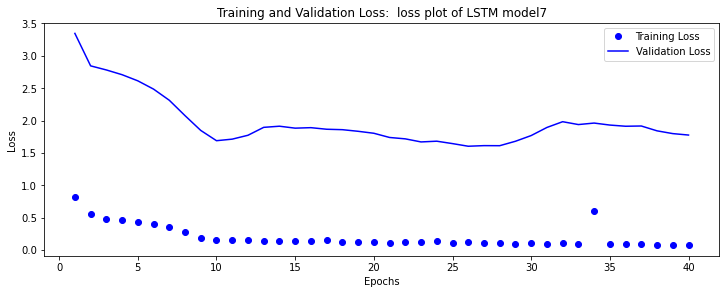

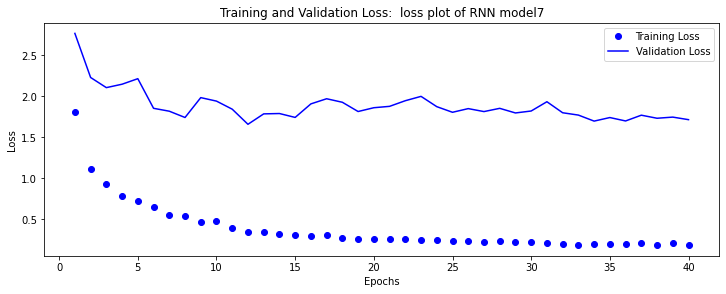

In [26]:
plot_simple_loss(LSTM_model7_history, "loss plot of LSTM model7")
plot_simple_loss(RNN_model7_history, "loss plot of RNN model7")

In [27]:
LSTM_model8 = models.Sequential()
LSTM_model8.add(layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, input_shape=(shape_1, shape_2)))

LSTM_model8.add(layers.LSTM(16, dropout=0.3, recurrent_dropout=0.3, activation='relu'))


LSTM_model8.add(layers.Dense(1))

LSTM_model8.compile(optimizer=RMSprop(), loss='mse')
LSTM_model8_history = LSTM_model8.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 8s 348ms/step - loss: 0.8056 - val_loss: 2.6315
Epoch 2/40
9/9 [==============================] - 3s 289ms/step - loss: 0.4048 - val_loss: 1.9270
Epoch 3/40
9/9 [==============================] - 3s 297ms/step - loss: 0.2083 - val_loss: 1.7263
Epoch 4/40
9/9 [==============================] - 3s 294ms/step - loss: 0.1310 - val_loss: 1.5959
Epoch 5/40
9/9 [==============================] - 3s 303ms/step - loss: 0.1156 - val_loss: 1.5483
Epoch 6/40
9/9 [==============================] - 3s 304ms/step - loss: 0.1046 - val_loss: 1.4689
Epoch 7/40
9/9 [==============================] - 3s 296ms/step - loss: 0.1019 - val_loss: 1.3728
Epoch 8/40
9/9 [==============================] - 4s 391ms/step - loss: 0.0941 - val_loss: 1.3778
Epoch 9/40
9/9 [==============================] - 3s 304ms/step - loss: 0.0946 - val_loss: 1.2769
Epoch 10/40
9/9 [==============================] - 3s 315ms/step - loss: 0.0850 - val_loss: 1.2942
Epoch 11/40
9/9 [==

In [28]:
RNN_model8 = models.Sequential()
RNN_model8.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, input_shape=(shape_1, shape_2)))

RNN_model8.add(layers.SimpleRNN(16, dropout=0.3, recurrent_dropout=0.3, activation='relu'))


RNN_model8.add(layers.Dense(1))

RNN_model8.compile(optimizer=RMSprop(), loss='mse')
RNN_model8_history = RNN_model8.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 4s 225ms/step - loss: 9.4610 - val_loss: 0.6967
Epoch 2/40
9/9 [==============================] - 2s 180ms/step - loss: 4.3993 - val_loss: 2.5309
Epoch 3/40
9/9 [==============================] - 2s 190ms/step - loss: 3.7214 - val_loss: 3.3504
Epoch 4/40
9/9 [==============================] - 2s 188ms/step - loss: 2.9983 - val_loss: 3.7331
Epoch 5/40
9/9 [==============================] - 2s 197ms/step - loss: 2.4722 - val_loss: 3.7006
Epoch 6/40
9/9 [==============================] - 2s 195ms/step - loss: 1.8661 - val_loss: 3.6433
Epoch 7/40
9/9 [==============================] - 1s 163ms/step - loss: 1.6644 - val_loss: 3.3435
Epoch 8/40
9/9 [==============================] - 2s 222ms/step - loss: 1.2560 - val_loss: 3.1942
Epoch 9/40
9/9 [==============================] - 2s 176ms/step - loss: 0.9488 - val_loss: 3.1818
Epoch 10/40
9/9 [==============================] - 2s 212ms/step - loss: 0.8713 - val_loss: 3.1062
Epoch 11/40
9/9 [==

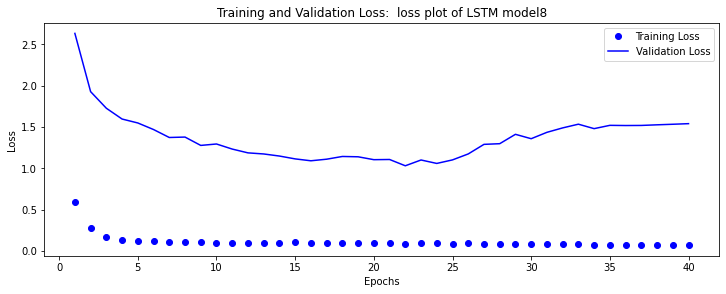

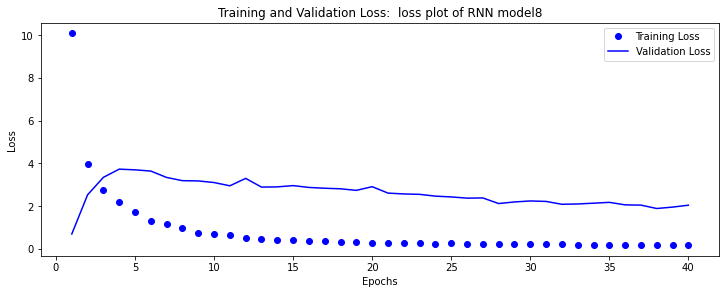

In [29]:
plot_simple_loss(LSTM_model8_history, "loss plot of LSTM model8")
plot_simple_loss(RNN_model8_history, "loss plot of RNN model8")